In [2]:
import rasterio
import numpy as np
from rasterio.plot import adjust_band
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_raster, reshape_as_image
from rasterio.plot import show
from rasterio.windows import Window
from pyproj import Proj, transform
import random
import math
import itertools
from tqdm import tqdm
from skimage import measure

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes, class_dict,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    # convert class_id to class_name using the class_dict
    cover_names = []
    for cover_class in classes:
        cover_names.append(class_dict[cover_class])
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    else:
        pass
    #print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=cover_names, yticklabels=cover_names,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

"""
TO Run: 

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

plt.show()
"""


'\nTO Run: \n\nnp.set_printoptions(precision=2)\n\n# Plot non-normalized confusion matrix\nplot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),\n                      class_dict=class_names)\n\n# Plot normalized confusion matrix\nplot_confusion_matrix(np.argmax(sk_label_batch_val, axis=1), pred_index, classes=np.array(list(class_names)),\n                      class_dict=class_names,\n                      normalize=True)\n\nplt.show()\n'

In [3]:
label_dataset = rasterio.open('/deep_data/landcover_reproject.tif')
label_image = label_dataset.read()

image_paths = ['/deep_data/processed_landsat/LC08_CU_027012_20170907_20181121_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028012_20140814_20171017_C01_V01_SR_combined.tif',
               '/deep_data/processed_landsat/LC08_CU_028011_20170907_20181130_C01_V01_SR_combined.tif',  
               '/deep_data/processed_landsat/LC08_CU_028012_20171002_20171019_C01_V01_SR_combined.tif']

landsat_datasets = []
for fp in image_paths:
    landsat_datasets.append(rasterio.open(fp))

In [117]:
def gen_pixel_locations(image_datasets, train_count, val_count, tile_size):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    ## future improvements could make this select classes evenly
    train_pixels = []
    val_pixels = []
    
    buffer = math.ceil(tile_size/2)
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    val_count_per_dataset = math.ceil(val_count / len(image_datasets))
   
    total_count_per_dataset = train_count_per_dataset + val_count_per_dataset
    for index, image_dataset in enumerate(tqdm(image_datasets)):
        #randomly pick `count` num of pixels from each dataset
        img_height, img_width = image_dataset.shape
        
        rows = range(0+buffer, img_height-buffer)
        columns = range(0+buffer, img_width-buffer)
        #rows_sub, columns_sub = zip(*random.sample(list(zip(rows, columns)), total_count))
        
        points = random.sample(set(itertools.product(rows, columns)), total_count_per_dataset)
        
        dataset_index_list = [index] * total_count_per_dataset
        
        dataset_pixels = list(zip(points, dataset_index_list))
        
        train_pixels += dataset_pixels[:train_count_per_dataset]
        val_pixels += dataset_pixels[train_count_per_dataset:]
        
        
    return (train_pixels, val_pixels)

In [71]:
label_image = label_dataset.read()
label_image[label_image == 255] = 1
    
class_count = len(np.unique(label_image))
#label_image = change_label_image(label_image)

def tile_generator(image_datasets, label_dataset, tile_height, tile_width, pixel_locations, batch_size):
    ### this is a keras compatible data generator which generates data and labels on the fly 
    ### from a set of pixel locations, a list of image datasets, and a label dataset
    
    # pixel locations looks like [r, c, dataset_index]

    #print("num unique = " + str(len(np.unique(label_image))))

    c = r = 0
    i = 0
    
    outProj = Proj(label_dataset.crs)

    # assuming all images have the same num of bands
    band_count = image_datasets[0].count
    
    buffer = math.ceil(tile_height / 2)
  
    while True:
        image_batch = np.zeros((batch_size, tile_height, tile_width, 7)) # take one off because we don't want the QA band
        label_batch = np.zeros((batch_size,class_count))
        b = 0
        while b < batch_size:
            # if we're at the end  of the data just restart
            if i >= len(pixel_locations):
                i=0
            c, r = pixel_locations[i][0]
            dataset_index = pixel_locations[i][1]
            i += 1
            tile = image_datasets[dataset_index].read(list(np.arange(1, band_count+1)), window=Window(c-buffer, r-buffer, tile_width, tile_height))
            if np.amax(tile) == 0: # don't include if it is part of the image with no pixels
                pass
            elif np.isnan(tile).any() == True or -9999 in tile: 
                # we don't want tiles containing nan or -999 this comes from edges
                # this also takes a while and is inefficient
                pass
            elif tile.shape != (band_count, tile_width, tile_height):
                print('wrong shape')
                print(tile.shape)
                # somehow we're randomly getting tiles without the correct dimensions
                pass
            elif np.isin(tile[7,:,:], [352, 368, 392, 416, 432, 480, 840, 864, 880, 904, 928, 944, 1352]).any() == True:
                # make sure pixel doesn't contain clouds
                # this is probably pretty inefficient but only checking width x height for each tile
                # read more here: https://prd-wret.s3-us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/LSDS-1873_US_Landsat_ARD_DFCB_0.pdf
                #print('Found some cloud.')
                #print(tile[7,:,:])
                pass
            else:
                tile = adjust_band(tile[0:7])
                # reshape from raster format to image format
                reshaped_tile = reshape_as_image(tile)
                #print(reshaped_tile.shape)

                # find gps of that pixel within the image
                (x, y) = image_datasets[dataset_index].xy(r, c)

                # convert the point we're sampling from to the same projection as the label dataset if necessary
                inProj = Proj(image_datasets[dataset_index].crs)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)

                # reference gps in label_image
                row, col = label_dataset.index(x,y)

                # find label
                label = label_image[:, row, col]
                # if this label is part of the unclassified area then ignore
                if label == 0 or np.isnan(label).any() == True:
                    pass
                else:
                    # add label to the batch in a one hot encoding style
                    label_batch[b][label] = 1
                    image_batch[b] = reshaped_tile[:,:,:]
                    b += 1
        yield (image_batch, label_batch)


In [35]:
train_data, val_data = gen_pixel_locations(image_datasets=landsat_datasets[:1], train_count=1000, val_count=1000, tile_size=2)




  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [00:14<00:00, 14.41s/it]

<BarContainer object of 23 artists>

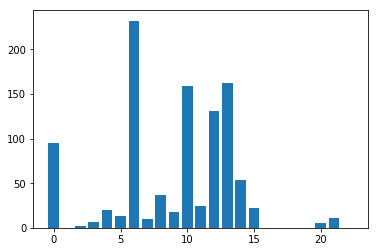

In [42]:
class_counts = [len(train_data[i]) for i in range(23)]
plt.bar(np.arange(23), class_counts)

In [6]:
def gen_balanced_pixel_locations(image_datasets, train_count, val_count, tile_size):
    ### this function pulls out a train_count + val_count number of random pixels from a list of raster datasets
    ### and returns a list of training pixel locations and image indices 
    ### and a list of validation pixel locations and indices
    
    ## future improvements could make this select classes evenly
    train_pixels = []
    val_pixels = []
    
    buffer = math.ceil(tile_size/2)
    
    train_count_per_dataset = math.ceil(train_count / len(image_datasets))
    val_count_per_dataset = math.ceil(val_count / len(image_datasets))
   
    total_count_per_dataset = train_count_per_dataset + val_count_per_dataset
    for index, image_dataset in enumerate(tqdm(image_datasets)):
        #randomly pick `count` num of pixels from each dataset
        img_height, img_width = image_dataset.shape
        
        rows = range(0+buffer, img_height-buffer)
        columns = range(0+buffer, img_width-buffer)
        #rows_sub, columns_sub = zip(*random.sample(list(zip(rows, columns)), total_count))
        
        # how many points from each class
        points_per_class = total_count_per_dataset // 23
        points_per_class_list = [[] for _ in range(23)]
        nppc = np.zeros(23)
        
        for cls in range(23):
            print(cls)
            mask_image = (label_image==cls).astype(int)[0]
            img_labeled = measure.label(mask_image, connectivity=2)
            bboxes = [area.bbox for area in measure.regionprops(img_labeled)]
            a = sorted(bboxes, key=lambda x: (x[2]-x[0]) * (x[3]-x[1]), reverse=True)
            coords = []
            for g in a:
                inProj = Proj(label_dataset.crs)
                outProj = Proj(image_dataset.crs)
                r, c = (g[0]+g[2])//2, (g[1]+g[3])//2
                (x, y) = label_dataset.xy(r, c)
                if inProj != outProj:
                    x,y = transform(inProj,outProj,x,y)
                row, col = image_dataset.index(x,y)
                if(0 + buffer <= row and row < img_height-buffer and 0+buffer <= col and col < img_width-buffer):
                    coords.append((row, col))
            i = 0
            while(len(points_per_class_list[cls]) < points_per_class):
                if (i >= len(coords)):
                    break
                row, col = coords[i]
                checkProj2 = Proj(label_dataset.crs)
                checkProj1 = Proj(image_dataset.crs)
                r, c =  row, col
                (x, y) = image_dataset.xy(r, c)

                x,y = transform(checkProj1,checkProj2,x,y)
                row1, col1 = label_dataset.index(x,y)

                # find label
                label = label_image[:, row1, col1]
                if (int(label) == cls):
                    points_per_class_list[cls].append(coords[i])
                    nppc[cls] += 1
                i += 1
            
            
    
        points = np.random.permutation(list(itertools.chain.from_iterable(points_per_class_list)))
        
        dataset_index_list = [index] * len(points)
        
        dataset_pixels = list(zip(points, dataset_index_list))
        
        train_count_ratio = int((train_count_per_dataset / total_count_per_dataset) * len(points))
        
        train_pixels += dataset_pixels[:train_count_ratio]
        val_pixels += dataset_pixels[train_count_ratio:]
        
        
    return (train_pixels, val_pixels)

In [96]:
train_px, val_px = gen_balanced_pixel_locations(image_datasets=landsat_datasets[:1], train_count=1000, val_count=500, tile_size=64)


  0%|          | 0/1 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22



100%|██████████| 1/1 [08:32<00:00, 512.08s/it]

In [97]:
train_px = [((t[0][0], t[0][1]), t[1]) for t in train_px]
val_px = [((t[0][0], t[0][1]), t[1]) for t in val_px]

In [62]:
random_loc = np.random.permutation(all_the_locations)

In [131]:
len(val_px)

349

In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
# The GPU id to use
# Patrick "0"
# Feroze  "1"
# Yousuf  "2"
# Diego   "3"
os.environ["CUDA_VISIBLE_DEVICES"]="1";

In [8]:
# Do other imports now...
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [72]:
batch_size = 25
tile_side = 11
input_shape = (tile_side, tile_side, 7)
num_classes = 23
weight_decay = 0.01

In [99]:
model = Sequential()

model.add(Conv2D(tile_side, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(Conv2D(22, (4, 4), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))



model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 9, 9, 11)          704       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 6, 6, 22)          3894      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 22)          0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 3, 3, 22)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 198)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               25472     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
__________

In [17]:
#train_px_real = [((t[0][0], t[0][1]), t[1]) for t in train_px]
val_px_real = [((t[0][0], t[0][1]), t[1]) for t in val_px]

In [127]:
print(sum(np.array(list(x in train_px for x in val_px)).astype(int))/len(val_px))

0.0


In [12]:
import pickle

In [129]:
with open('val2', 'wb') as fp:
    pickle.dump(val_px, fp)

In [93]:
val_px = [((t[0][0], t[0][1]), t[1]) for t in val_px]

In [100]:
sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#sgd = keras.optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
metrics=['accuracy']

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=metrics)
history = model.fit_generator(generator=tile_generator(landsat_datasets[:1], label_dataset, tile_side, tile_side, train_px_real, batch_size), 
                    steps_per_epoch=len(train_px_real) // batch_size, epochs=600, verbose=1,
                    validation_data=tile_generator(landsat_datasets[:1], label_dataset, tile_side, tile_side, val_px_real, batch_size),
                    validation_steps=len(val_px_real) // batch_size,
                   shuffle=True)

Epoch 1/600
27/27 [==============================] - 1s 42ms/step - loss: 2.9355 - acc: 0.1526 - val_loss: 2.3678 - val_acc: 0.2123
Epoch 2/600
27/27 [==============================] - 1s 39ms/step - loss: 2.3904 - acc: 0.2015 - val_loss: 2.1666 - val_acc: 0.2338
Epoch 3/600
27/27 [==============================] - 1s 40ms/step - loss: 2.2395 - acc: 0.2252 - val_loss: 2.1683 - val_acc: 0.2000
Epoch 4/600
27/27 [==============================] - 1s 39ms/step - loss: 2.2367 - acc: 0.2267 - val_loss: 2.1319 - val_acc: 0.2400
Epoch 5/600
27/27 [==============================] - 1s 39ms/step - loss: 2.2101 - acc: 0.2267 - val_loss: 2.1230 - val_acc: 0.2215
Epoch 6/600
27/27 [==============================] - 1s 38ms/step - loss: 2.2079 - acc: 0.2311 - val_loss: 2.1247 - val_acc: 0.2154
Epoch 7/600
27/27 [==============================] - 1s 40ms/step - loss: 2.1693 - acc: 0.2533 - val_loss: 2.1035 - val_acc: 0.2308
Epoch 8/600
27/27 [==============================] - 1s 39ms/step - loss: 2.

27/27 [==============================] - 1s 39ms/step - loss: 1.1455 - acc: 0.5822 - val_loss: 1.6410 - val_acc: 0.5877
Epoch 63/600
27/27 [==============================] - 1s 39ms/step - loss: 1.1943 - acc: 0.5733 - val_loss: 1.5834 - val_acc: 0.6277
Epoch 64/600
27/27 [==============================] - 1s 38ms/step - loss: 1.1028 - acc: 0.5956 - val_loss: 1.4663 - val_acc: 0.5908
Epoch 65/600
27/27 [==============================] - 1s 39ms/step - loss: 1.1510 - acc: 0.5985 - val_loss: 1.6863 - val_acc: 0.6154
Epoch 66/600
27/27 [==============================] - 1s 39ms/step - loss: 1.0939 - acc: 0.6133 - val_loss: 1.6297 - val_acc: 0.6185
Epoch 67/600
27/27 [==============================] - 1s 39ms/step - loss: 0.9761 - acc: 0.6474 - val_loss: 1.5657 - val_acc: 0.6338
Epoch 68/600
27/27 [==============================] - 1s 38ms/step - loss: 1.1018 - acc: 0.5867 - val_loss: 1.6488 - val_acc: 0.6492
Epoch 69/600
27/27 [==============================] - 1s 39ms/step - loss: 1.0350 

27/27 [==============================] - 1s 38ms/step - loss: 0.4289 - acc: 0.8430 - val_loss: 1.8522 - val_acc: 0.7477
Epoch 124/600
27/27 [==============================] - 1s 39ms/step - loss: 0.4706 - acc: 0.8237 - val_loss: 1.7060 - val_acc: 0.7385
Epoch 125/600
27/27 [==============================] - 1s 39ms/step - loss: 0.5304 - acc: 0.8193 - val_loss: 1.8745 - val_acc: 0.7292
Epoch 126/600
27/27 [==============================] - 1s 38ms/step - loss: 0.4816 - acc: 0.8222 - val_loss: 1.9803 - val_acc: 0.7292
Epoch 127/600
27/27 [==============================] - 1s 41ms/step - loss: 0.4894 - acc: 0.8207 - val_loss: 1.7825 - val_acc: 0.7354
Epoch 128/600
27/27 [==============================] - 1s 39ms/step - loss: 0.4122 - acc: 0.8593 - val_loss: 1.8066 - val_acc: 0.7446
Epoch 129/600
27/27 [==============================] - 1s 39ms/step - loss: 0.4425 - acc: 0.8356 - val_loss: 1.7644 - val_acc: 0.7477
Epoch 130/600
27/27 [==============================] - 1s 40ms/step - loss: 

27/27 [==============================] - 1s 40ms/step - loss: 0.3398 - acc: 0.8933 - val_loss: 2.1065 - val_acc: 0.7415
Epoch 185/600
27/27 [==============================] - 1s 39ms/step - loss: 0.3380 - acc: 0.8830 - val_loss: 2.0159 - val_acc: 0.7538
Epoch 186/600
27/27 [==============================] - 1s 40ms/step - loss: 0.2854 - acc: 0.9052 - val_loss: 2.1847 - val_acc: 0.7323
Epoch 187/600
27/27 [==============================] - 1s 39ms/step - loss: 0.3069 - acc: 0.8978 - val_loss: 2.0040 - val_acc: 0.7477
Epoch 188/600
27/27 [==============================] - 1s 39ms/step - loss: 0.2905 - acc: 0.9081 - val_loss: 2.0134 - val_acc: 0.7569
Epoch 189/600
27/27 [==============================] - 1s 39ms/step - loss: 0.2375 - acc: 0.9274 - val_loss: 2.0580 - val_acc: 0.7477
Epoch 190/600
27/27 [==============================] - 1s 39ms/step - loss: 0.2582 - acc: 0.9111 - val_loss: 2.2066 - val_acc: 0.7508
Epoch 191/600
27/27 [==============================] - 1s 40ms/step - loss: 

27/27 [==============================] - 1s 39ms/step - loss: 0.2404 - acc: 0.9304 - val_loss: 2.2750 - val_acc: 0.7754
Epoch 246/600
27/27 [==============================] - 1s 40ms/step - loss: 0.2896 - acc: 0.9111 - val_loss: 2.1653 - val_acc: 0.7446
Epoch 247/600
27/27 [==============================] - 1s 40ms/step - loss: 0.2604 - acc: 0.9141 - val_loss: 2.0864 - val_acc: 0.7569
Epoch 248/600
27/27 [==============================] - 1s 40ms/step - loss: 0.2691 - acc: 0.9126 - val_loss: 2.1708 - val_acc: 0.7508
Epoch 249/600
27/27 [==============================] - 1s 39ms/step - loss: 0.2671 - acc: 0.9156 - val_loss: 2.2263 - val_acc: 0.7538
Epoch 250/600
27/27 [==============================] - 1s 39ms/step - loss: 0.2476 - acc: 0.9215 - val_loss: 2.2815 - val_acc: 0.7477
Epoch 251/600
27/27 [==============================] - 1s 40ms/step - loss: 0.2007 - acc: 0.9348 - val_loss: 2.3133 - val_acc: 0.7538
Epoch 252/600
27/27 [==============================] - 1s 40ms/step - loss: 

27/27 [==============================] - 1s 40ms/step - loss: 0.2434 - acc: 0.9185 - val_loss: 2.3587 - val_acc: 0.7600
Epoch 307/600
27/27 [==============================] - 1s 38ms/step - loss: 0.1687 - acc: 0.9348 - val_loss: 2.2843 - val_acc: 0.7477
Epoch 308/600
27/27 [==============================] - 1s 39ms/step - loss: 0.2739 - acc: 0.9170 - val_loss: 2.3910 - val_acc: 0.7600
Epoch 309/600
27/27 [==============================] - 1s 39ms/step - loss: 0.2767 - acc: 0.9185 - val_loss: 2.5496 - val_acc: 0.7415
Epoch 310/600
27/27 [==============================] - 1s 41ms/step - loss: 0.1873 - acc: 0.9244 - val_loss: 2.4543 - val_acc: 0.7385
Epoch 311/600
27/27 [==============================] - 1s 38ms/step - loss: 0.2333 - acc: 0.9244 - val_loss: 2.4773 - val_acc: 0.7569
Epoch 312/600
27/27 [==============================] - 1s 39ms/step - loss: 0.1948 - acc: 0.9348 - val_loss: 2.2550 - val_acc: 0.7477
Epoch 313/600
27/27 [==============================] - 1s 40ms/step - loss: 

27/27 [==============================] - 1s 39ms/step - loss: 0.1370 - acc: 0.9496 - val_loss: 2.2496 - val_acc: 0.7477
Epoch 368/600
27/27 [==============================] - 1s 39ms/step - loss: 0.1804 - acc: 0.9452 - val_loss: 2.3086 - val_acc: 0.7569
Epoch 369/600
27/27 [==============================] - 1s 38ms/step - loss: 0.1813 - acc: 0.9452 - val_loss: 2.3694 - val_acc: 0.7508
Epoch 370/600
27/27 [==============================] - 1s 39ms/step - loss: 0.1900 - acc: 0.9363 - val_loss: 2.4657 - val_acc: 0.7538
Epoch 371/600
27/27 [==============================] - 1s 38ms/step - loss: 0.2169 - acc: 0.9348 - val_loss: 2.3806 - val_acc: 0.7508
Epoch 372/600
27/27 [==============================] - 1s 38ms/step - loss: 0.1812 - acc: 0.9378 - val_loss: 2.3019 - val_acc: 0.7662
Epoch 373/600
27/27 [==============================] - 1s 38ms/step - loss: 0.1720 - acc: 0.9333 - val_loss: 2.3484 - val_acc: 0.7631
Epoch 374/600
27/27 [==============================] - 1s 39ms/step - loss: 

27/27 [==============================] - 1s 38ms/step - loss: 0.2386 - acc: 0.9333 - val_loss: 2.5133 - val_acc: 0.7354
Epoch 429/600
27/27 [==============================] - 1s 38ms/step - loss: 0.1455 - acc: 0.9452 - val_loss: 2.5533 - val_acc: 0.7415
Epoch 430/600
27/27 [==============================] - 1s 40ms/step - loss: 0.1131 - acc: 0.9719 - val_loss: 2.4637 - val_acc: 0.7538
Epoch 431/600
27/27 [==============================] - 1s 40ms/step - loss: 0.2333 - acc: 0.9422 - val_loss: 2.5257 - val_acc: 0.7600
Epoch 432/600
27/27 [==============================] - 1s 39ms/step - loss: 0.1610 - acc: 0.9556 - val_loss: 2.3811 - val_acc: 0.7446
Epoch 433/600
27/27 [==============================] - 1s 41ms/step - loss: 0.1644 - acc: 0.9333 - val_loss: 2.6005 - val_acc: 0.7508
Epoch 434/600
27/27 [==============================] - 1s 39ms/step - loss: 0.1404 - acc: 0.9541 - val_loss: 2.4782 - val_acc: 0.7354
Epoch 435/600
27/27 [==============================] - 1s 39ms/step - loss: 

27/27 [==============================] - 1s 40ms/step - loss: 0.1679 - acc: 0.9526 - val_loss: 2.5942 - val_acc: 0.7569
Epoch 490/600
27/27 [==============================] - 1s 38ms/step - loss: 0.1932 - acc: 0.9437 - val_loss: 2.2521 - val_acc: 0.7631
Epoch 491/600
27/27 [==============================] - 1s 39ms/step - loss: 0.1490 - acc: 0.9467 - val_loss: 2.2743 - val_acc: 0.7600
Epoch 492/600
27/27 [==============================] - 1s 39ms/step - loss: 0.2305 - acc: 0.9363 - val_loss: 2.5193 - val_acc: 0.7538
Epoch 493/600
27/27 [==============================] - 1s 40ms/step - loss: 0.1426 - acc: 0.9585 - val_loss: 2.5070 - val_acc: 0.7538
Epoch 494/600
27/27 [==============================] - 1s 39ms/step - loss: 0.1693 - acc: 0.9556 - val_loss: 2.4331 - val_acc: 0.7538
Epoch 495/600
27/27 [==============================] - 1s 39ms/step - loss: 0.1569 - acc: 0.9496 - val_loss: 2.3836 - val_acc: 0.7415
Epoch 496/600
27/27 [==============================] - 1s 40ms/step - loss: 

27/27 [==============================] - 1s 38ms/step - loss: 0.1505 - acc: 0.9615 - val_loss: 2.5588 - val_acc: 0.7508
Epoch 551/600
27/27 [==============================] - 1s 38ms/step - loss: 0.1269 - acc: 0.9511 - val_loss: 2.6357 - val_acc: 0.7446
Epoch 552/600
27/27 [==============================] - 1s 40ms/step - loss: 0.1508 - acc: 0.9407 - val_loss: 2.6814 - val_acc: 0.7508
Epoch 553/600
27/27 [==============================] - 1s 41ms/step - loss: 0.1679 - acc: 0.9541 - val_loss: 2.5077 - val_acc: 0.7538
Epoch 554/600
27/27 [==============================] - 1s 39ms/step - loss: 0.1483 - acc: 0.9585 - val_loss: 2.4102 - val_acc: 0.7723
Epoch 555/600
27/27 [==============================] - 1s 38ms/step - loss: 0.1253 - acc: 0.9630 - val_loss: 2.5578 - val_acc: 0.7508
Epoch 556/600
27/27 [==============================] - 1s 38ms/step - loss: 0.1276 - acc: 0.9570 - val_loss: 2.6215 - val_acc: 0.7508
Epoch 557/600
27/27 [==============================] - 1s 39ms/step - loss: 

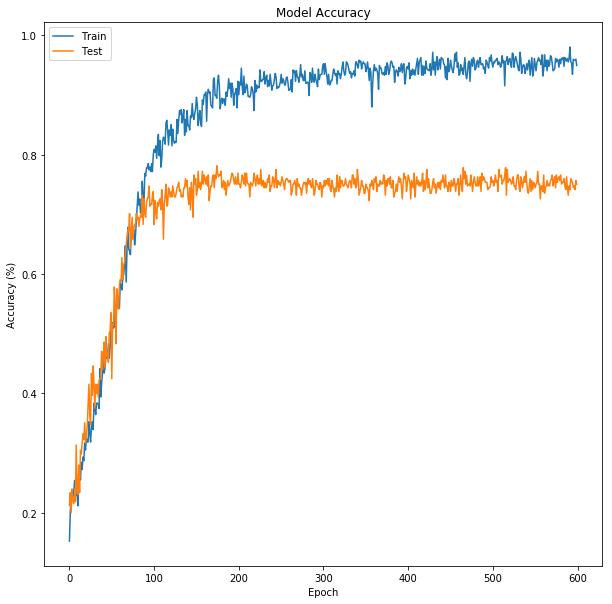

In [106]:
plt.figure(figsize=(10,10))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


In [124]:
test_px, _ = gen_balanced_pixel_locations(image_datasets=landsat_datasets[:1], 
                                       train_count=500, val_count=0, tile_size=tile_side)


  0%|          | 0/1 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

In [125]:
test_px_real = val_px

In [120]:
test_px_real = [((t[0][0], t[0][1]), t[1]) for t in test_px]

13/13 [==============================] - 0s 26ms/step


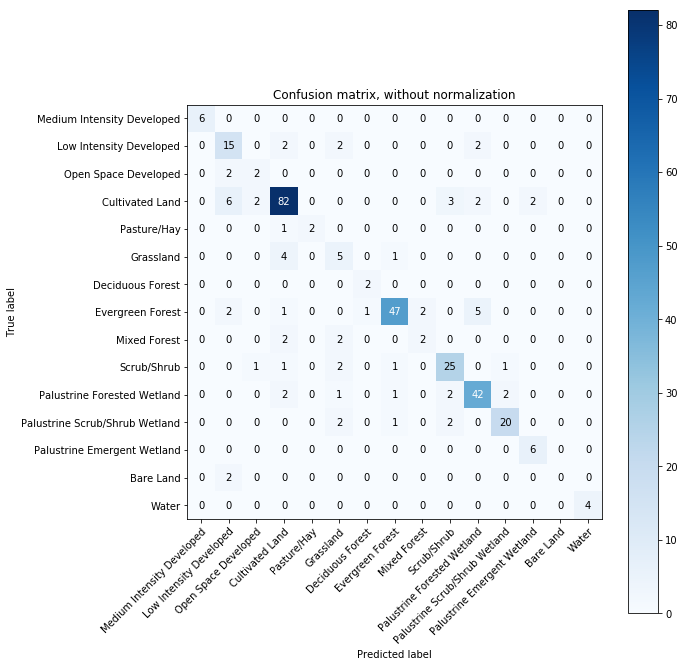

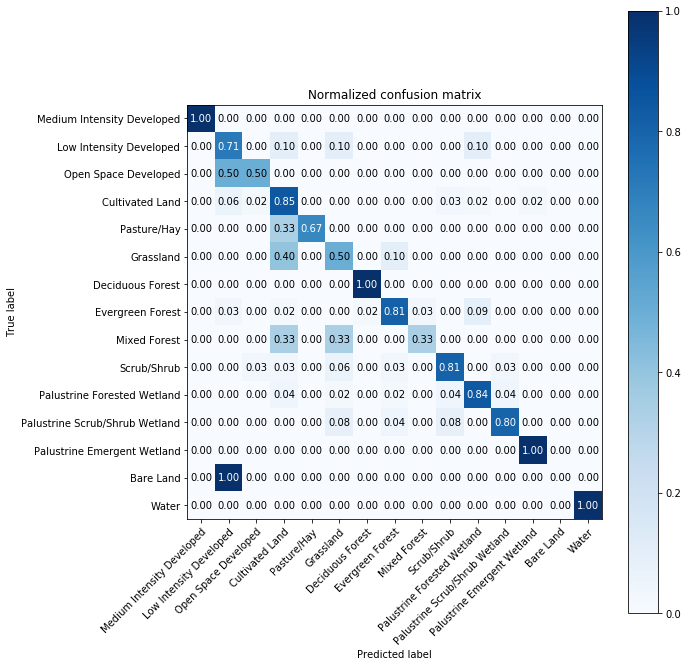

In [126]:
predictions = model.predict_generator(generator=tile_generator(landsat_datasets[:1], label_dataset, tile_side, tile_side, test_px_real, batch_size), 
                        steps=len(test_px_real) // batch_size,
                         verbose=1)
eval_generator = tile_generator(landsat_datasets[:1], label_dataset, tile_side, tile_side, test_px_real, batch_size=1)
labels = np.empty(predictions.shape)
count = 0
while count < len(labels):
    image_b, label_b = next(eval_generator)
    labels[count] = label_b
    count += 1
    
label_index = np.argmax(labels, axis=1)     
pred_index = np.argmax(predictions, axis=1)

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names)

# Plot normalized confusion matrix
plot_confusion_matrix(label_index, pred_index, classes=np.array(list(class_names)),
                      class_dict=class_names,
                      normalize=True)

In [123]:
model.evaluate_generator(generator=tile_generator(landsat_datasets[:1], label_dataset, tile_side, tile_side, test_px_real, batch_size), 
                        steps=len(test_px) // batch_size,
                         verbose=1)

20/20 [==============================] - 0s 20ms/step


[6.344176733493805, 0.2779999990016222]

In [35]:
test_px

[[[(1632, 4733), 0],
  [(536, 4692), 0],
  [(567, 4121), 0],
  [(252, 4691), 0],
  [(819, 4209), 0],
  [(1807, 4691), 0],
  [(931, 4971), 0],
  [(283, 237), 0],
  [(269, 168), 0],
  [(197, 4526), 0],
  [(114, 4180), 0],
  [(1698, 4889), 0],
  [(984, 4366), 0],
  [(700, 3703), 0],
  [(765, 4777), 0],
  [(733, 4346), 0],
  [(662, 3644), 0],
  [(1121, 3951), 0],
  [(8, 4275), 0],
  [(123, 3595), 0],
  [(244, 3762), 0],
  [(1590, 4746), 0],
  [(88, 4883), 0],
  [(146, 4156), 0],
  [(232, 272), 0],
  [(628, 4149), 0],
  [(1058, 4251), 0],
  [(671, 4474), 0],
  [(534, 4734), 0],
  [(414, 4417), 0],
  [(480, 4717), 0],
  [(1365, 4876), 0],
  [(983, 4390), 0],
  [(512, 4095), 0],
  [(1075, 3944), 0],
  [(1263, 4577), 0],
  [(1710, 4476), 0],
  [(207, 288), 0],
  [(743, 4838), 0],
  [(795, 4350), 0],
  [(225, 4867), 0],
  [(72, 4531), 0],
  [(173, 358), 0],
  [(972, 4284), 0],
  [(1297, 4510), 0],
  [(719, 3685), 0],
  [(1043, 4278), 0],
  [(1389, 4221), 0],
  [(578, 4831), 0],
  [(474, 4531), 

In [45]:
class_names = dict((
(0,  'Background'),
(1, 'Unclassified'),
(2, 'High Intensity Developed'),
(3, 'Medium Intensity Developed'),
(4, 'Low Intensity Developed'),
(5, 'Open Space Developed'),
(6, 'Cultivated Land'),
(7, 'Pasture/Hay'),
(8, 'Grassland'),
(9, 'Deciduous Forest'),
(10, 'Evergreen Forest'),
(11, 'Mixed Forest'),
(12, 'Scrub/Shrub'),
(13, 'Palustrine Forested Wetland'),
(14, 'Palustrine Scrub/Shrub Wetland'),
(15, 'Palustrine Emergent Wetland'),
(16, 'Estuarine Forested Wetland'),
(17, 'Estuarine Scrub/Shrub Wetland'),
(18, 'Estuarine Emergent Wetland'),
(19, 'Unconsolidated Shore'),
(20, 'Bare Land'),
(21, 'Water'),
(22, 'Palustrine Aquatic Bed'),
(23, 'Estuarine Aquatic Bed'),
(24, 'Tundra'),
(25, 'Snow/Ice')
))